In [1]:
from configuration import configuration as cfg

import cv2
import numpy as np
import torch
from model_factory import prepare_model
from torch.utils.data import DataLoader
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import os

from architectures import SiameseSimple, distance_euclid, distance_canberra
from dataset_io import SimilarityDataset

from metrics import tpr_fpr, plot_ROC

In [2]:
config = cfg('config.json')
config.add('device', 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {config.device} device')

Using cuda device


In [28]:
# training_desc = 'Train_on100x16imagesLeaky_e50_b32_lr0.002/'
training_desc = f'{config.distance}/Train_on{config.max_samples}x{config.max_images}imagesChanging{int(config.other_images)}Leaky_m{config.margin}_e{config.epochs}_b{config.batch_size}_lr{config.learning_rate}_o{config.out_channels}/'
models_root = 'models/' + training_desc
model, model_name, model_epoch = prepare_model(SiameseSimple, models_root, config.device, save_config=False, verbose=True)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─0.weight
|    └─3.weight
|    └─Conv2d: 2-1                       320
|    └─LeakyReLU: 2-2                    --
|    └─MaxPool2d: 2-3                    --
|    └─BatchNorm2d: 2-4                  64
├─Sequential: 1-2                        --
|    └─0.weight
|    └─3.weight
|    └─Conv2d: 2-5                       18,496
|    └─LeakyReLU: 2-6                    --
|    └─MaxPool2d: 2-7                    --
|    └─BatchNorm2d: 2-8                  128
├─Sequential: 1-3                        --
|    └─0.weight
|    └─2.weight
|    └─Conv2d: 2-9                       36,928
|    └─LeakyReLU: 2-10                   --
|    └─BatchNorm2d: 2-11                 128
├─Sequential: 1-4                        --
|    └─0.weight
|    └─3.weight
|    └─Conv2d: 2-12                      36,928
|    └─LeakyReLU: 2-13                   --
|    └─MaxPool2d: 2-14                   --
|    └─BatchNorm

In [ ]:
training_desc + model_name

In [12]:
max_samples = 20
max_images = 12
test_data = SimilarityDataset('data/test', max_samples=max_samples, max_images=max_images)

Data: 100%|██████████| 52/52 [00:01<00:00, 33.19it/s]


In [8]:
test_data.reset(True)

In [13]:
samples_predicted = []
for i in range(max_images):
    all_samples = test_data.get_samples(i)
    print(i, test_data.image_names[i])
    embeddings = model.forward_branch(all_samples.to(config.device))
    labels = np.zeros((len(embeddings), 1), dtype=np.int32) + i
    embeddings = torch.squeeze(embeddings)
    samples_predicted.append(np.concatenate((labels, embeddings.to('cpu').detach().numpy()), axis=1))

0 data/test\pexels-photo-113338.jpg
1 data/test\pexels-photo-122458.jpg
2 data/test\pexels-photo-127567.jpg
3 data/test\pexels-photo-129722.jpg
4 data/test\pexels-photo-129723.jpg
5 data/test\pexels-photo-129731.jpg
6 data/test\pexels-photo-159062.jpg
7 data/test\pexels-photo-161690.jpg
8 data/test\pexels-photo-162846.jpg
9 data/test\pexels-photo-166651.jpg
10 data/test\pexels-photo-173207.jpg
11 data/test\pexels-photo-179088.jpg


In [26]:
len(samples_predicted)

8

In [14]:
samples = np.concatenate(samples_predicted, axis=0)

In [7]:
samples[40:50, 1]

array([-1.26374257, -0.83214641, -0.61140651, -1.04576838, -1.35063624,
       -1.1603533 , -1.07222903, -1.22775638, -1.22443259, -0.78112954])

In [15]:
fig = px.scatter_3d(samples[:, 1:4], x=0, y=1, z=2, color=samples[:, 0],
                    title='Embeddings', labels={'0': 'x', '1': 'y', '2': 'z'}, opacity=0.5)
fig.show()

In [19]:
test_batch_size = 16
test_dataloader = DataLoader(test_data, test_batch_size, shuffle=True, num_workers=0)

# Evaluate Metrics and Save predicted samples

1. Run the mkdirs

In [16]:
save_to = 'data/predictions/' + training_desc
if not os.path.exists(save_to):
    os.makedirs(save_to + '/tp')
    os.makedirs(save_to + '/tn')
    os.makedirs(save_to + '/fp')
    os.makedirs(save_to + '/fn')
save_name = 'E_{:02d}-b_{:03d}-d_{:.4f}.jpg'
split = np.ones((1, config.image_size[1], 3))
save_files = False
compute_metrics = False

2. Then set the threshold variable for default value

In [17]:
thresh = 1.0

Just a quick visualization of name for the files

In [9]:
save_name.format(3, 20, 0.34423424)

'E_03-b_020-d_0.3442.jpg'

3. Run the cell to compute the distances vector and y_true

... look further
5. Run the cell to compute it with optimal threshold and save image pairs

In [26]:
# because I don't want to
save_files = False

In [34]:
# accuracy_mean = 0
# precision_mean = 0
# recall_mean = 0
batches = 0
distance_vector = []
y_true = []
tp = 0
tn = 0
fp = 0
fn = 0
for epoch in range(10):
    test_data.reset(True)
    for batch, (x1, x2, y) in tqdm(enumerate(test_dataloader), total=int(np.ceil(len(test_data) / test_batch_size))):
        out1, out2 = model.forward(x1.to(config.device), x2.to(config.device))
        distance, _ = distance_euclid(out1, out2)
        distance_vector = np.concatenate((distance_vector, distance.detach().cpu().numpy()), axis=0)
        y_true = np.concatenate((y_true, y.cpu().numpy()), axis=0)
        if compute_metrics:
            for dist, s1, s2, t in zip(distance, x1, x2, y):
                if dist < thresh and t:
                    tp += 1
                    if save_files:
                        cv2.imwrite(os.path.join(save_to, 'tp', save_name.format(epoch, batch, dist)),
                                    np.concatenate((s1.numpy(), split, s2.numpy()), axis=2).transpose([1, 2, 0]) * 255)
                elif dist < thresh and not t:
                    fp += 1
                    if save_files:
                        cv2.imwrite(os.path.join(save_to, 'fp', save_name.format(epoch, batch, dist)),
                                    np.concatenate((s1.numpy(), split, s2.numpy()), axis=2).transpose([1, 2, 0]) * 255)
                elif dist >= thresh and not t:
                    tn += 1
                    if save_files:
                        cv2.imwrite(os.path.join(save_to, 'tn', save_name.format(epoch, batch, dist)),
                                    np.concatenate((s1.numpy(), split, s2.numpy()), axis=2).transpose([1, 2, 0]) * 255)
                elif dist >= thresh and t:
                    fn += 1
                    if save_files:
                        cv2.imwrite(os.path.join(save_to, 'fn', save_name.format(epoch, batch, dist)),
                                    np.concatenate((s1.numpy(), split, s2.numpy()), axis=2).transpose([1, 2, 0]) * 255)

        # similarity = (distance < thresh).float()
        # correct = (similarity==y.to(device)).float().sum()
        # accuracy_mean += correct/x1.shape[0]
        # precision_mean += torch.sum((similarity * y.to(device))) / torch.sum((similarity * y.to(device)) + (similarity * (y.to(device)*-1+1)))
        # recall_mean += torch.sum((similarity * y.to(device))) / torch.sum((similarity * y.to(device)) + ((similarity*-1+1) * y.to(device)))
        batches += 1

# print(f"Test Accuracy: {accuracy_mean/batches}")
# print(f"Test Precision: {precision_mean/batches}")
# print(f"Test Recall: {recall_mean/batches}")

100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


In [37]:
if compute_metrics:
    print(f"Test Accuracy: {(tp + tn) / (tp + tn + fp + fn)}")
    print(f"Test Precision: {(tp) / (tp + fp)}")
    print(f"Test Recall: {(tp) / (tp + fn)}")
    with open(os.path.join(models_root,'metrics.txt'), 'w') as metrics_file:
        metrics_file.write(config.distance)
        metrics_file.write(f"Test Accuracy: {(tp + tn) / (tp + tn + fp + fn)}\n")
        metrics_file.write(f"Test Precision: {(tp) / (tp + fp)}\n")
        metrics_file.write(f"Test Recall: {(tp) / (tp + fn)}\n")
# _, axs = plt.subplots(1, config.batch_size, figsize=[12, 4])
# for ii, (i1, i2, t, d) in enumerate(zip(x1, x2, y, distance)):
#     axs[ii].imshow(torch.cat((i1, i2), dim=1).permute(1, 2, 0), cmap='gray')
#     axs[ii].set_title("D: {:.3f} Y:{:.1f}".format(d.item(), t.item()))
# plt.show()
# plt.close()

Test Accuracy: 0.71375
Test Precision: 0.7228496959165943
Test Recall: 0.6933333333333334


4. Run the next two cells to compute thresholds and ROC curve

... go back to previous cell

In [23]:
distance_vector.max()

46.68342971801758

In [24]:
tprs = []
fprs = []
val = int(np.ceil(distance_vector.max()*100))
thresholds = np.array(list(range(val))) / 100
for i in range(val):
    tpr, fpr = tpr_fpr(distance_vector, y_true, i / 100)
    tprs.append(tpr)
    fprs.append(fpr)

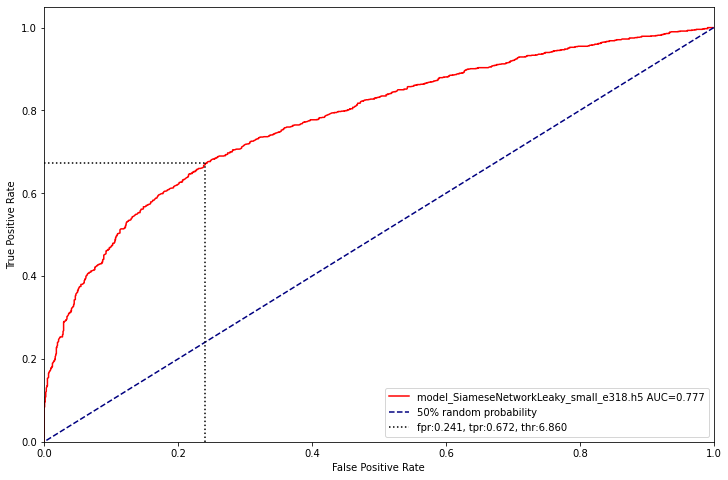

6.86 0.776739236111111


In [25]:
thresh, auc = plot_ROC(tprs, fprs, thresholds, model_name.format(model_epoch, 0), 'red', save_path=os.path.join(models_root,'roc.pdf'))
print(thresh, auc)
save_files = True
compute_metrics = True

Try this shit (aka prediction and 3d scatterplot visualization) with whole images

In [ ]:
pather = lambda x: os.path.join('data/test', x)
files = list(map(pather, os.listdir('data/test')))


class data:
    def __init__(self, files):
        self.samples = [
            np.array(np.transpose(np.expand_dims(cv2.imread(x, cv2.IMREAD_GRAYSCALE) / 255, axis=2), axes=[2, 0, 1]),
                     dtype=np.float32) for x in files]

    def get_samples(self, item):
        return torch.from_numpy(np.expand_dims(self.samples[item], axis=0))


whole_data = data(files)

In [ ]:
for i, f in enumerate(files):
    print(i, f)

In [47]:
samples_predicted = []
for i in range(len(whole_data.samples)):
    all_samples = whole_data.get_samples(i)
    # print(test_data.image_names[i])
    embeddings = model.forward_branch(all_samples.to(config.device))
    embeddings = torch.squeeze(embeddings)
    samples_predicted.append(np.concatenate(([i], embeddings.to('cpu').detach().numpy()), axis=0))

In [ ]:
fig = px.scatter_3d(np.array(samples_predicted)[:, 1:4], x=0, y=1, z=2, color=np.array(samples_predicted)[:, 0],
                    title='Embeddings', labels={'0': 'x', '1': 'y', '2': 'z'}, opacity=0.5)
fig.show()
